In [16]:
import h5py

# Load data from an h5 file
with h5py.File(r'K:\499-ProjectData\2025\P25-0048_Thyroid_Recurrence\06-UNI-adaptation\embeddings\test_thyroid_embeddings.h5', 'r') as f:
    # List all groups/datasets in the file
    print("Keys in the h5 file:", list(f.keys()))
    
    # Load embeddings metadata and sample codes into python structures for analysis
    metadata = {key: f['metadata'][key][:] for key in f['metadata'].keys()}
    sample_codes = f['sample_codes'][:]
    embeddings = f['embeddings'][:]
    print("Loaded embeddings shape:", embeddings.shape)


Keys in the h5 file: ['embeddings', 'metadata', 'sample_codes']
Loaded embeddings shape: (2131779, 1536)
Loaded embeddings shape: (2131779, 1536)


In [18]:
sample_codes[0]

b'002_B05.20964B'

In [ ]:
import pandas as pd

# Load CSV file
df = pd.read_csv(r'K:\499-ProjectData\2025\P25-0048_Thyroid_Recurrence\04-Processed_Datasets\extracted_metadata.csv')
print(df.head())



            Batch  #  Year       ID Lett. cancer_type
0  1st-Carcinomas  1  B05.  20964.0     A  Carcinomas
1  1st-Carcinomas  2  B05.  20964.0     B  Carcinomas
2  1st-Carcinomas  3  B05.  23505.0     H  Carcinomas
3  1st-Carcinomas  4  B05.   7206.0     D  Carcinomas
4  1st-Carcinomas  5  B05.  10626.0     C  Carcinomas


In [21]:
# Create mapping from sample codes to batch using #, Year, and ID
# Sample codes look like: b'002_B05.20964B'
# The sample code contains #, Year, and ID as substrings, and together they uniquely identify a sample

def map_sample_to_batch(sample_code, df):
    """
    Map a sample code to its batch by finding the row in df where
    #, Year, and ID are all substrings of the sample code.
    
    Args:
        sample_code: The sample code (string or bytes), e.g., '002_B05.20964B'
        df: DataFrame with columns '#', 'Year', 'ID', and 'Batch'
        
    Returns:
        Batch value or None if not found
    """
    # Decode if bytes
    if isinstance(sample_code, bytes):
        sample_code = sample_code.decode('utf-8')
    
    sample_code_str = str(sample_code).upper()  # Convert to uppercase for case-insensitive matching
    
    # Find matching row where all three fields are substrings of sample_code
    for idx, row in df.iterrows():
        # Convert each field to string and check if it's a substring
        # Handle NaN values and convert to uppercase
        
        # Handle # field: convert to int to remove decimals (e.g., 2.0 -> 2)
        hash_val = str(int(row['#'])) if pd.notna(row['#']) else ''
        
        # Handle Year field: keep as string
        year_val = str(row['Year']).upper() if pd.notna(row['Year']) else ''
        
        # Handle ID field: convert float to int to remove decimal point (e.g., 20964.0 -> 20964)
        if pd.notna(row['ID']):
            try:
                # Try to convert to int (removes .0 if it's a float)
                id_val = str(int(float(row['ID']))).upper()
            except (ValueError, TypeError):
                # If conversion fails, just use string representation
                id_val = str(row['ID']).upper()
        else:
            id_val = ''
        
        # Skip empty values
        if not hash_val or not year_val or not id_val:
            continue
        
        # Check if all three are substrings
        if (hash_val in sample_code_str and
            year_val in sample_code_str and
            id_val in sample_code_str):
            return row['Batch']
    
    return None  # No match found

# Create batch mapping for all sample codes
print("Creating sample code to batch mapping...")
print(f"Example sample code: {sample_codes[0]}")

sample_code_to_batch = {}
unique_sample_codes = np.unique(sample_codes)

# Track mapping for debugging
mapped_count = 0
failed_samples = []

for sample_code in unique_sample_codes:
    batch = map_sample_to_batch(sample_code, df)
    sample_code_key = sample_code if isinstance(sample_code, str) else sample_code.decode('utf-8')
    sample_code_to_batch[sample_code_key] = batch
    
    if batch is not None:
        mapped_count += 1
    else:
        failed_samples.append(sample_code_key)

# Create batch array aligned with sample_codes
# Convert None to 'Unknown' to avoid issues
batch_array = np.array([
    sample_code_to_batch.get(sc.decode('utf-8') if isinstance(sc, bytes) else sc, 'Unknown') or 'Unknown'
    for sc in sample_codes
])

# Add batch to metadata
metadata['batch'] = batch_array

# Print summary
print(f"\nMapping summary:")
print(f"  Total unique sample codes: {len(unique_sample_codes)}")
print(f"  Successfully mapped: {mapped_count}")
print(f"  Failed to map: {len(failed_samples)}")

if failed_samples:
    print(f"\nFailed to map the following samples:")
    for sample in failed_samples[:10]:  # Show first 10
        print(f"    {sample}")
    if len(failed_samples) > 10:
        print(f"    ... and {len(failed_samples) - 10} more")

# Filter out None and 'Unknown' before sorting
unique_batches = sorted([b for b in set(batch_array) if b and b != 'Unknown'])
print(f"\nUnique batches found: {unique_batches}")
print(f"\nBatch distribution:")
batch_counts = pd.Series(batch_array).value_counts()
for batch, count in batch_counts.items():
    print(f"  {batch}: {count:,} patches")

Creating sample code to batch mapping...
Example sample code: b'002_B05.20964B'

Mapping summary:
  Total unique sample codes: 132
  Successfully mapped: 130
  Failed to map: 2

Failed to map the following samples:
    033_B10.9063D
    097_B22.9080D

Unique batches found: [np.str_('1st-Carcinomas'), np.str_('2nd-Carcinomas'), np.str_('Adenomas'), np.str_('MiniBatch-Preliminary study'), np.str_('MiniBatch-Proteomics Fresh Frozen Tissues')]

Batch distribution:
  2nd-Carcinomas: 993,723 patches
  1st-Carcinomas: 630,509 patches
  Adenomas: 409,983 patches
  Unknown: 46,968 patches
  MiniBatch-Proteomics Fresh Frozen Tissues: 40,068 patches
  MiniBatch-Preliminary study: 10,528 patches

Mapping summary:
  Total unique sample codes: 132
  Successfully mapped: 130
  Failed to map: 2

Failed to map the following samples:
    033_B10.9063D
    097_B22.9080D

Unique batches found: [np.str_('1st-Carcinomas'), np.str_('2nd-Carcinomas'), np.str_('Adenomas'), np.str_('MiniBatch-Preliminary study'

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import numpy as np

# PCA reduction to 2D
print("Computing PCA...")
pca = PCA(n_components=2, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)
print(f"PCA completed. Shape: {embeddings_pca.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

Computing PCA...
PCA completed. Shape: (2131779, 2)
Explained variance ratio: [0.19840522 0.11566923]


In [ ]:
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

def plot_pca_interactive(n_points=10000, tissue_threshold=0.0, color_by='has_invasion'):
    """
    Interactive PCA plot with controls for number of points, tissue threshold, and coloring.
    
    Parameters:
    - n_points: Number of points to plot
    - tissue_threshold: Minimum tissue percentage threshold
    - color_by: Metadata field to use for coloring (or 'sample_code'/'batch' for categorical coloring)
    """
    # Filter by tissue percentage
    tissue_mask = metadata['tissue_percentage'] >= tissue_threshold
    
    # Apply filter
    filtered_indices = np.where(tissue_mask)[0]
    
    # Limit to n_points
    if len(filtered_indices) > n_points:
        selected_indices = np.random.choice(filtered_indices, n_points, replace=False)
    else:
        selected_indices = filtered_indices
    
    # Get PCA coordinates
    pca_subset = embeddings_pca[selected_indices]
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    # Handle categorical coloring (sample_code or batch)
    if color_by == 'sample_code':
        # Get sample codes for selected patches
        sample_codes_selected = sample_codes[selected_indices]
        
        # Create unique sample mapping
        unique_samples = np.unique(sample_codes_selected)
        sample_to_int = {sample: i for i, sample in enumerate(unique_samples)}
        color_values = np.array([sample_to_int[sample] for sample in sample_codes_selected])
        
        # Create categorical colormap with distinct colors
        n_categories = len(unique_samples)
        if n_categories <= 10:
            colors = plt.cm.tab10(np.linspace(0, 1, 10))[:n_categories]
        elif n_categories <= 20:
            colors = plt.cm.tab20(np.linspace(0, 1, 20))[:n_categories]
        else:
            colors = plt.cm.hsv(np.linspace(0, 0.95, n_categories))
        
        # Create discrete colormap
        cmap_categorical = ListedColormap(colors)
        
        scatter = plt.scatter(pca_subset[:, 0], pca_subset[:, 1], 
                             c=color_values, cmap=cmap_categorical, 
                             alpha=0.6, s=10, vmin=-0.5, vmax=n_categories-0.5)
        
        plt.colorbar(scatter, label='Sample Code (discrete colors)', ticks=[])
        title_extra = f"\nColored by: Sample Code ({n_categories} unique samples)"
        
    elif color_by == 'batch':
        # Get batches for selected patches
        batches_selected = metadata['batch'][selected_indices]
        
        # Create unique batch mapping
        unique_batches = np.unique(batches_selected)
        batch_to_int = {batch: i for i, batch in enumerate(unique_batches)}
        color_values = np.array([batch_to_int[batch] for batch in batches_selected])
        
        # Create categorical colormap with distinct colors
        n_batches = len(unique_batches)
        if n_batches <= 10:
            colors = plt.cm.tab10(np.linspace(0, 1, 10))[:n_batches]
        elif n_batches <= 20:
            colors = plt.cm.tab20(np.linspace(0, 1, 20))[:n_batches]
        else:
            colors = plt.cm.hsv(np.linspace(0, 0.95, n_batches))
        
        # Create discrete colormap
        cmap_categorical = ListedColormap(colors)
        
        scatter = plt.scatter(pca_subset[:, 0], pca_subset[:, 1], 
                             c=color_values, cmap=cmap_categorical, 
                             alpha=0.6, s=10, vmin=-0.5, vmax=n_batches-0.5)
        
        # Create colorbar with batch names
        cbar = plt.colorbar(scatter, label='Batch', ticks=np.arange(n_batches))
        cbar.set_ticklabels(unique_batches, fontsize=9)
        
        title_extra = f"\nColored by: Batch ({n_batches} unique batches)"
        
    else:
        # Standard metadata coloring
        color_values = metadata[color_by][selected_indices]
        
        # Choose colormap based on data type
        if color_by == 'has_invasion':
            cmap = 'RdYlGn_r'  # Red for invasion, green for no invasion
        elif color_by in ['invasion_type', 'invasion_percentage']:
            cmap = 'Reds'
        elif color_by == 'tissue_percentage':
            cmap = 'Blues'
        else:
            cmap = 'viridis'
        
        scatter = plt.scatter(pca_subset[:, 0], pca_subset[:, 1], 
                             c=color_values, cmap=cmap, alpha=0.6, s=10)
        plt.colorbar(scatter, label=color_by)
        title_extra = f"\nColored by: {color_by}"
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.title(f'PCA of Embeddings (n={len(selected_indices)}, tissue≥{tissue_threshold}%)' + title_extra)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Create dropdown options: sample_code, batch, then other metadata fields
dropdown_options = ['sample_code', 'batch'] + [k for k in metadata.keys() if k != 'batch']

# Create interactive widget
interact(
    plot_pca_interactive,
    n_points=IntSlider(min=1000, max=100000, step=1000, value=10000, description='N Points:'),
    tissue_threshold=FloatSlider(min=0.0, max=100.0, step=1.0, value=0.0, description='Tissue %:'),
    color_by=Dropdown(
        options=dropdown_options,
        value='has_invasion',
        description='Color by:'
    )
)

interactive(children=(IntSlider(value=10000, description='N Points:', max=100000, min=1000, step=1000), FloatS…

<function __main__.plot_pca_interactive(n_points=10000, tissue_threshold=0.0, color_by='has_invasion')>

Patches with >0% tissue: 1,304,315
Filtered out: 827,464 patches with 0% tissue


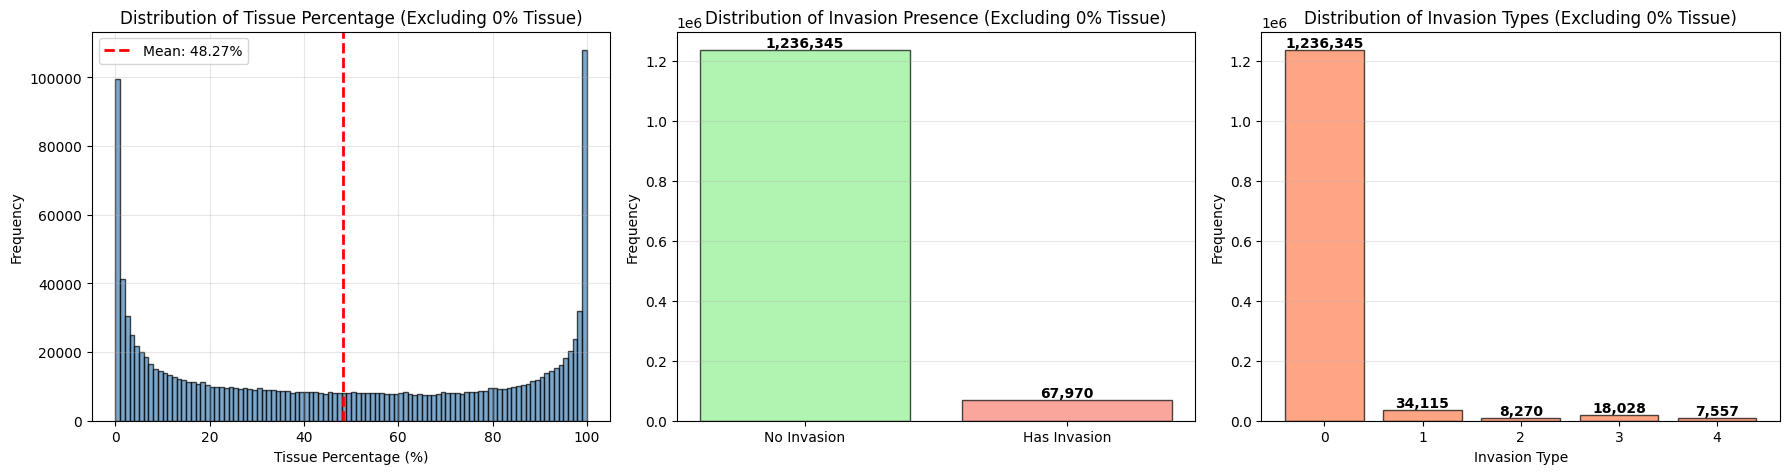


=== Summary Statistics (Excluding 0% Tissue) ===
Tissue percentage - Mean: 48.27%
Tissue percentage - Median: 45.92%
Tissue percentage - Std: 36.16%
Tissue percentage - Min: 0.00%
Tissue percentage - Max: 100.00%


In [7]:
# Create filtered metadata excluding patches with 0% tissue
non_zero_tissue_mask = metadata['tissue_percentage'] > 0.0

filtered_metadata = {
    'tissue_percentage': metadata['tissue_percentage'][non_zero_tissue_mask],
    'has_invasion': metadata['has_invasion'][non_zero_tissue_mask],
    'invasion_type': metadata['invasion_type'][non_zero_tissue_mask]
}

print(f"Patches with >0% tissue: {len(filtered_metadata['tissue_percentage']):,}")
print(f"Filtered out: {zero_tissue_count:,} patches with 0% tissue")

# Plot histograms excluding 0% tissue patches
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Tissue percentage histogram (excluding 0%)
axes[0].hist(filtered_metadata['tissue_percentage'], bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Tissue Percentage (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Tissue Percentage (Excluding 0% Tissue)')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(filtered_metadata['tissue_percentage'].mean(), 
                color='red', linestyle='--', linewidth=2, label=f"Mean: {filtered_metadata['tissue_percentage'].mean():.2f}%")
axes[0].legend()

# Plot 2: Invasion presence (excluding 0% tissue)
invasion_counts_filtered = pd.Series(filtered_metadata['has_invasion']).value_counts()
axes[1].bar(['No Invasion', 'Has Invasion'], 
            [invasion_counts_filtered.get(False, 0), invasion_counts_filtered.get(True, 0)],
            edgecolor='black', alpha=0.7, color=['lightgreen', 'salmon'])
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Invasion Presence (Excluding 0% Tissue)')
axes[1].grid(True, alpha=0.3, axis='y')
for i, (label, count) in enumerate(zip(['No Invasion', 'Has Invasion'], 
                                         [invasion_counts_filtered.get(False, 0), invasion_counts_filtered.get(True, 0)])):
    axes[1].text(i, count, f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Invasion types (excluding 0% tissue)
invasion_type_counts_filtered = pd.Series(filtered_metadata['invasion_type']).value_counts().sort_index()
axes[2].bar(invasion_type_counts_filtered.index, invasion_type_counts_filtered.values, 
            edgecolor='black', alpha=0.7, color='coral')
axes[2].set_xlabel('Invasion Type')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of Invasion Types (Excluding 0% Tissue)')
axes[2].set_xticks(invasion_type_counts_filtered.index)
axes[2].grid(True, alpha=0.3, axis='y')
for x, y in zip(invasion_type_counts_filtered.index, invasion_type_counts_filtered.values):
    axes[2].text(x, y, f'{y:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n=== Summary Statistics (Excluding 0% Tissue) ===")
print(f"Tissue percentage - Mean: {filtered_metadata['tissue_percentage'].mean():.2f}%")
print(f"Tissue percentage - Median: {np.median(filtered_metadata['tissue_percentage']):.2f}%")
print(f"Tissue percentage - Std: {filtered_metadata['tissue_percentage'].std():.2f}%")
print(f"Tissue percentage - Min: {filtered_metadata['tissue_percentage'].min():.2f}%")
print(f"Tissue percentage - Max: {filtered_metadata['tissue_percentage'].max():.2f}%")

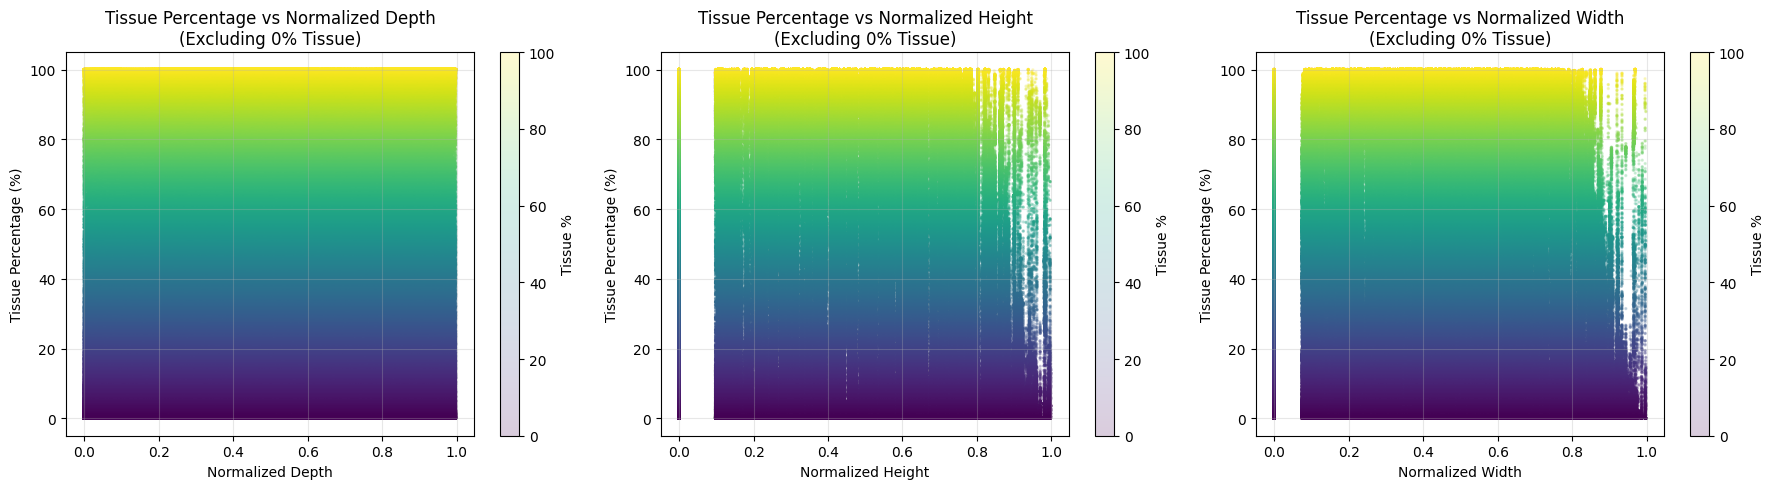

Plotted 1,304,315 patches with >0% tissue


In [8]:
# Scatter plots of normalized coordinates vs tissue percentage (excluding 0% tissue)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Get filtered normalized coordinates
filtered_coord_d = metadata['coord_d_normalized'][non_zero_tissue_mask]
filtered_coord_h = metadata['coord_h_normalized'][non_zero_tissue_mask]
filtered_coord_w = metadata['coord_w_normalized'][non_zero_tissue_mask]

# Plot 1: Tissue percentage vs normalized depth (excluding 0%)
scatter1 = axes[0].scatter(filtered_coord_d, filtered_metadata['tissue_percentage'], 
                           alpha=0.2, s=2, c=filtered_metadata['tissue_percentage'], 
                           cmap='viridis', vmin=0, vmax=100)
axes[0].set_xlabel('Normalized Depth')
axes[0].set_ylabel('Tissue Percentage (%)')
axes[0].set_title('Tissue Percentage vs Normalized Depth\n(Excluding 0% Tissue)')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Tissue %')

# Plot 2: Tissue percentage vs normalized height (excluding 0%)
scatter2 = axes[1].scatter(filtered_coord_h, filtered_metadata['tissue_percentage'], 
                           alpha=0.2, s=2, c=filtered_metadata['tissue_percentage'], 
                           cmap='viridis', vmin=0, vmax=100)
axes[1].set_xlabel('Normalized Height')
axes[1].set_ylabel('Tissue Percentage (%)')
axes[1].set_title('Tissue Percentage vs Normalized Height\n(Excluding 0% Tissue)')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Tissue %')

# Plot 3: Tissue percentage vs normalized width (excluding 0%)
scatter3 = axes[2].scatter(filtered_coord_w, filtered_metadata['tissue_percentage'], 
                           alpha=0.2, s=2, c=filtered_metadata['tissue_percentage'], 
                           cmap='viridis', vmin=0, vmax=100)
axes[2].set_xlabel('Normalized Width')
axes[2].set_ylabel('Tissue Percentage (%)')
axes[2].set_title('Tissue Percentage vs Normalized Width\n(Excluding 0% Tissue)')
axes[2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[2], label='Tissue %')

plt.tight_layout()
plt.show()

print(f"Plotted {len(filtered_metadata['tissue_percentage']):,} patches with >0% tissue")